## Classification Model with Linear Model

In [6]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [7]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

In [8]:
import parse_inputs

from pathlib import Path

import numpy as np
import pandas as pd
from pandas_plink import read_plink

from sklearn import linear_model
from sklearn.svm import SVR

from ggplot import *
PATH=Path('ddat/crowdAI/')
TMP_PATH = PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)

/home/ahmadA/anaconda3/envs/fastai/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/ahmadA/anaconda3/envs/fastai/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/ahmadA/anaconda3/envs/fastai/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Data load

X is genotype and gender , y is height

### Taizhao data

plink --bfile all2964/bin_final_strand --merge-list merge_file.txt --make-bed --out tzosmerged
plink --bfile all2964/bin_final_strand --exclude tzosmerged-merge.missnp --make-bed --out bin_final_strand_m1
plink --bfile OpenSNP_train --exclude tzosmerged-merge.missnp --make-bed --out OpenSNP_train_m1
plink --bfile OpenSNP_test --exclude tzosmerged-merge.missnp --make-bed --out OpenSNP_test_m1
plink --bfile bin_final_strand_m1 --merge-list merge_file.txt --make-bed --out tzosmerged_m1
plink --bfile tzosmerged_m1 --check-sex --out tzosmerged_m2

In [ ]:
from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components=20)
Y_sklearn = sklearn_pca.fit_transform(mpl[2].T)

In [ ]:
import numpy as np
import dask.array as da
from dask_ml.decomposition import PCA
dX = mpl[2].T
pca = PCA(n_components=20)
pca.fit(dX)
print(pca.explained_variance_ratio_)  
print(pca.singular_values_)  

Mapping files: 100%|██████████| 3/3 [00:04<00:00,  2.21s/it]


all samples 2747 male 989 female 1758


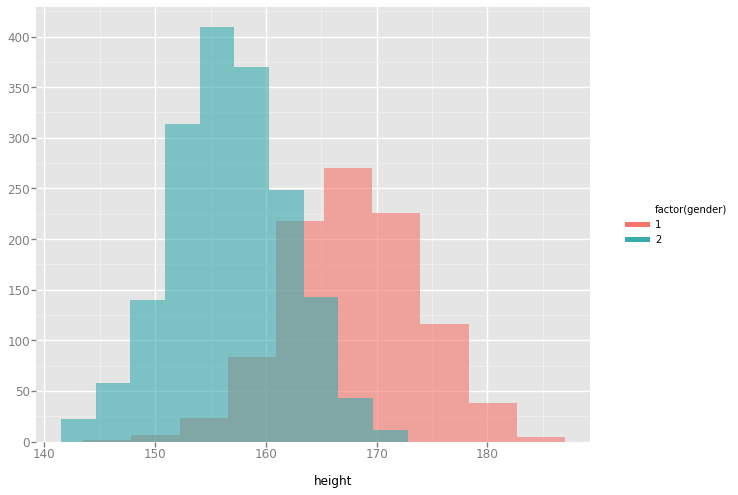

<ggplot: (-9223363244999757224)>

In [11]:
(tz_bim,tz_fam,tz_bed) = read_plink('ddat/crowdAI/all2964/bin_final_strand')
tz_f_meta = pd.read_csv(PATH/'TZ14_height_f_v2.csv')
tz_m_meta = pd.read_csv(PATH/'TZ14_height_m_v2.csv')
tz_meta = tz_m_meta.append(tz_f_meta,ignore_index=True)
print("all samples",len(tz_meta),'male',len(tz_m_meta),'female',len(tz_f_meta))
ggplot( aes(x='height',fill='factor(gender)'),data=tz_meta) +\
    geom_histogram(alpha=0.6)

### Opensnp data

Training data

Mapping files: 100%|██████████| 3/3 [00:21<00:00, 10.03s/it]


opensnp training data 783


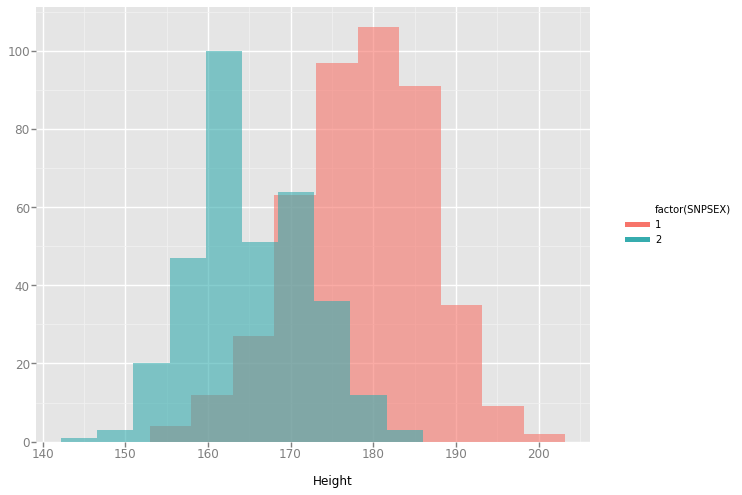

<ggplot: (8791681440106)>

In [12]:
(os_bim, os_fam, os_bed) = read_plink('ddat/crowdAI/OpenSNP_train')
os_meta = pd.read_csv(PATH/'opensnp_metadat.csv',index_col=0)
os_meta = os_meta.loc[os_meta.SNPSEX>0,]
print('opensnp training data',len(os_meta))
ggplot( aes(x='Height',fill='factor(SNPSEX)'),data=os_meta) +\
    geom_histogram(alpha=0.6)

Test data

In [13]:
os_plink_test = read_plink('ddat/crowdAI/OpenSNP_test')
os_meta_test = pd.read_csv(PATH/'opensnp_trianandtest_metadata.csv',index_col=0)
os_meta_test=os_meta_test.loc[[int(x) for x in list(os_plink_test[1].iid)]]
#check iid and gender
#sum(os_meta_test.IID.eq([int(x) for x in list(os_plink_test[1].iid)])),len(os_meta_test)
#sum(os_meta_test.SNPSEX>0),sum(os_meta_test.SNPSEX.isna())
print('opensnp test data',len(os_meta_test),'male',sum(os_meta_test.SNPSEX==1))

Mapping files: 100%|██████████| 3/3 [00:54<00:00, 25.49s/it]


opensnp test data 137 male 78


In [32]:
os_meta_test.to_csv(TMP_PATH/'os_meta_test.csv')

# Data Cleaning 

### Meta data integration

all train and val samples 3530 tz 2747 os 783 male 1435


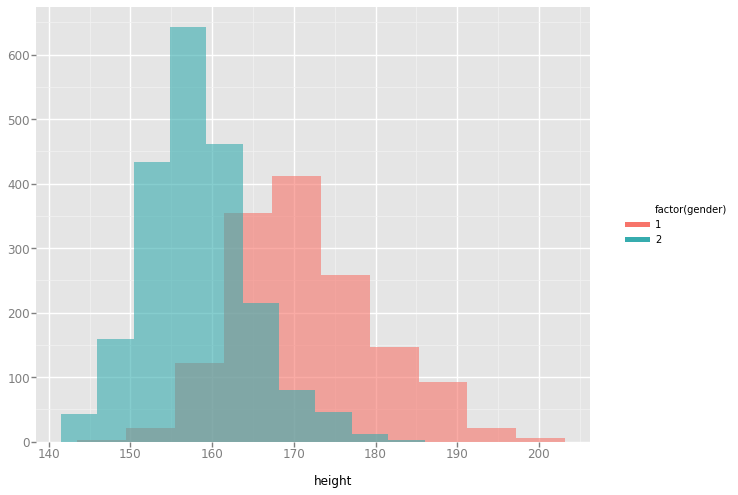

<ggplot: (-9223363245213539689)>

In [14]:
new_os_meta=os_meta.iloc[:,[1,7,0,4,3]]
tz_meta=tz_meta.iloc[:,0:5]
new_os_meta.columns=tz_meta.columns
all_meta = tz_meta.append(new_os_meta,ignore_index=True)
print('all train and val samples',len(all_meta),'tz',len(tz_meta),'os',len(new_os_meta),'male',sum(all_meta.gender==1))

ggplot( aes(x='height',fill='factor(gender)'),data=all_meta) +\
    geom_histogram(alpha=0.6)

## get genotype  

get common genotype with top 10000 list  >>>7726

In [15]:
snps = pd.read_csv(PATH/'snps_sorted_p_val_v2.csv')

In [16]:
common_snp = set(snps.snp[0:10000]).intersection(*(tz_bim.snp,os_bim.snp))
len(common_snp)

7726

common snp index in tz and os train data

In [17]:
tz_snp1996_index = [i for i,x in enumerate(tz_bim.snp) if x in common_snp]
os_snp1996_index = [i for i,x in enumerate(os_bim.snp) if x in common_snp]
len(tz_snp1996_index),len(os_snp1996_index)

(7726, 7727)

samples match with meta data

In [18]:
all_meta = pd.read_csv(TMP_PATH/'tz_and_os_meta.csv',index_col=0)
tz_sample_index = [i for i,x in enumerate(tz_fam.iid) if x in list(all_meta.ChipID)]
os_sample_index = [i for i,x in enumerate(os_fam.iid) if x in list(all_meta.ChipID)]
len(tz_sample_index),len(os_sample_index)

(2747, 783)

#### get sub snp and samples

In [19]:
def plink_slice(p,pb=None,pf=None):
    """
    p: list of bim, fam, bed
    pb: index of bim
    pf: index of fam
    """
    (bim,fam,bed)=p
    if pb:
        bim = bim.iloc[pb]
        bed = bed[pb,:]
    if pf:
        fam = fam.iloc[pf]
        bed = bed[:,pf]
    return(bim,fam,bed)

In [20]:
tz_sub=plink_slice((tz_bim,tz_fam,tz_bed),tz_snp1996_index,tz_sample_index)
os_sub=plink_slice((os_bim,os_fam,os_bed),os_snp1996_index,os_sample_index)

#### get sub test sample

In [21]:
os_sub_test=plink_slice(os_plink_test,os_snp1996_index)
#check test sample and training sample having same snps
print(os_sub_test[0].shape,os_sub[0].shape)
print(os_sub_test[0].iloc[:,0:4].equals(os_sub[0].iloc[:,0:4]))
#but some of them have opposite a0 and a1
sum([x==y for x,y in zip(os_sub_test[0].a0,os_sub[0].a0)])

(7727, 7) (7727, 7)
True


7420

### remove duplicated rs6790793 T A

In [22]:
os_sub[0][os_sub[0].snp.duplicated()],os_sub[0][os_sub[0].snp=='rs6790793'],tz_sub[0][tz_sub[0].snp=='rs6790793']

(        chrom        snp   cm        pos a0 a1        i
 1594752     3  rs6790793  0.0  190918063  T  A  1594752,
         chrom        snp   cm        pos a0 a1        i
 1594751     3  rs6790793  0.0  190918063  C  A  1594751
 1594752     3  rs6790793  0.0  190918063  T  A  1594752,
        chrom        snp   cm        pos a0 a1       i
 174759     3  rs6790793  0.0  190918063  C  A  174759)

In [23]:
os_sub_test[0][os_sub_test[0].snp.duplicated()],os_sub_test[0][os_sub_test[0].snp=='rs6790793']

(        chrom        snp   cm        pos a0 a1        i
 1594752     3  rs6790793  0.0  190918063  T  A  1594752,
         chrom        snp   cm        pos a0 a1        i
 1594751     3  rs6790793  0.0  190918063  C  A  1594751
 1594752     3  rs6790793  0.0  190918063  T  A  1594752)

In [24]:
dup_snp_idx = list(np.where(-os_sub[0].snp.duplicated())[0])

In [25]:
os_sub = plink_slice(os_sub,dup_snp_idx)
os_sub_test=plink_slice(os_sub_test,dup_snp_idx)

In [26]:
print(os_sub_test[0].shape,os_sub[0].shape)
print(os_sub_test[0].iloc[:,0:4].equals(os_sub[0].iloc[:,0:4]))
#but some of them have opposite a0 and a1
sum([x==y for x,y in zip(os_sub_test[0].a0,os_sub[0].a0)])

(7726, 7) (7726, 7)
True


7419

## align a0 and a1 to a ref. (reverse 0 and 2 genotype)

In [27]:
def align_a0_a1(refp,p):
    refbim=refp[0].reset_index(drop=True)
    pbim=p[0].reset_index(drop=True)
    if refbim.snp.equals(pbim.snp) and refbim.pos.equals(pbim.pos):
        diff_idx=[x!=y for x,y in zip(refbim.a0,pbim.a0)]
        if all([x==y for x,y in zip(refbim.a0[diff_idx],pbim.a1[diff_idx])]):
            pbed = pd.DataFrame(p[2].compute())
            tmp = pbed.copy()
            #tmp1 = pbed.copy()
            tmp = tmp.iloc[diff_idx,:]
            #tmp1 = tmp1.iloc[diff_idx,:]
            tmp.replace([0,2],[2,0],inplace=True)
            pbed.loc[diff_idx]=tmp
            return pbed
        else:
            print("can't alignment")
    else:
        print('error happens in align')

align genotype of opensnp traing and test data to taizhao

In [28]:
os_sub_align = align_a0_a1(tz_sub,os_sub)
os_sub_test_align = align_a0_a1(tz_sub,os_sub_test)

In [31]:
os_sub_test_align.to_pickle(TMP_PATH/'os_sub_test_bed_top10000.pk')

## Merge training data from taizhou and opensnp 

In [29]:
all_bim = tz_sub[0]
all_fam = tz_sub[1].append(os_sub[1])
#row sample and column snps
all_bed_T= pd.DataFrame(tz_sub[2].compute()).T.append(os_sub_align.T)
all_bim.shape,all_fam.shape,all_bed_T.shape

((7726, 7), (3530, 7), (3530, 7726))

In [115]:
all_bim.to_pickle(TMP_PATH/'all_bim_top10000.pk')

In [116]:
all_fam.to_pickle(TMP_PATH/'all_fam_top10000.pk')

In [117]:
all_bed_T.to_pickle(TMP_PATH/'all_bed_T_top10000.pk')

In [ ]:
all_meta.index = all_meta.ChipID
all_meta=all_meta.loc[all_fam.iid,]

In [126]:
all_meta.to_csv(TMP_PATH/'tz_and_os_meta.csv')

# Build Model

## Data Prepare

In [10]:
all_bed_T = pd.read_pickle(TMP_PATH/'all_bed_T_top10000.pk')

In [165]:
sum(tmp.astype(np.float32))

783.0

In [276]:
X = all_bed_T
X['gender'] = pd.Series(list(all_meta.gender),index=X.index)
X['nationality'] = pd.Series(list((all_meta.nationality=='PROBLEM').astype(np.int)),index=X.index)
X.fillna(-1,inplace=True)
y = all_meta.height

df_test = os_sub_test_align.T
df_test['gender']=pd.Series(list(os_meta_test.SNPSEX[[int(x) for x in list(os_plink_test[1].iid)]]),index=df_test.index)
df_test['nationality'] = 1
#Replace nan values in the training and testing set with an arbitrary number (-1)
df_test.fillna(-1,inplace=True)

In [277]:
def y_boolean(x,m,f,g):
    if g==1:
        return int(x>m)
    elif g==2:
        return int(x>f)
    else:
        print('error')

m50 = np.percentile(y.loc[list(X.gender==1)],50)
f50 = np.percentile(y.loc[list(X.gender==2)],50)
yb= [y_boolean(x,m50,f50,X.gender.iloc[i]) for i,x in enumerate(y)]

In [270]:
facet_grid(yb~)

1763

In [278]:
y=yb

In [255]:
sum(np.logical_and(X.gender==1,X.nationality==0))

989

In [256]:
np.percentile(y.loc[list(np.logical_and(X.gender==1,X.nationality==0))],75)

172.0

In [257]:
np.percentile(y.loc[list(X.gender==2)],75)

162.0

## Linear Model

In [119]:
from sklearn import linear_model
import crowdai

In [172]:
#Load training data
x_train = X
y_train = y
x_test = df_test

# Instantiate a linear model
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)

# Predict the heights for the test set
heights = regr.predict(x_test)
#Convert heights from np.array to a list (to ensure it is JSON serializable)
heights = heights.tolist()

# Create the challenge object by authentication with crowdAI with your API_KEY
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
challenge.submit(heights)
challenge.disconnect()

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 9e4d1eb2-42ae-4263-b679-316d1c4d82cf


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 9e4d1eb2-42ae-4263-b679-316d1c4d82cf


100% |██████████|[00:01<00:00]  97.09% /s] 


CrowdAI.Event.Job.INFO : (9e4d1eb2-42ae-4263-b679-316d1c4d82cf) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -5.29085540972e+17 ; MSE : 5.37841814384e+19
CrowdAI.Event.Job.COMPLETE : 9e4d1eb2-42ae-4263-b679-316d1c4d82cf	   🍺 


### Linear model (gender and nationality)

In [232]:
#Load training data
x_train = X[['gender','nationality']]
y_train = y
x_test = df_test[['gender','nationality']]

# Instantiate a linear model
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)

# Predict the heights for the test set
heights = regr.predict(x_test)
#Convert heights from np.array to a list (to ensure it is JSON serializable)
heights = heights.tolist()

# Create the challenge object by authentication with crowdAI with your API_KEY
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
challenge.submit(heights)
challenge.disconnect()

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 26831063-42c6-4fe1-8a06-b605596ec3bb


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 26831063-42c6-4fe1-8a06-b605596ec3bb


100% |██████████|[00:00<00:00]  107.85% /s] 


CrowdAI.Event.Job.INFO : (26831063-42c6-4fe1-8a06-b605596ec3bb) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.418981198924 ; MSE : 59.0634560883
CrowdAI.Event.Job.COMPLETE : 26831063-42c6-4fe1-8a06-b605596ec3bb	   🍺 


In [234]:
from sklearn.model_selection import cross_val_score
clf = linear_model.Lasso()
scores = cross_val_score(clf, X, y, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

In [235]:
# Predict the heights for the test set
heights = clf.predict(x_test)
#Convert heights from np.array to a list (to ensure it is JSON serializable)
heights = heights.tolist()

# Create the challenge object by authentication with crowdAI with your API_KEY
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
challenge.submit(heights)
challenge.disconnect()

NotFittedError: This Lasso instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [233]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X_Train, Y_Train, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size=0.2)
clf = linear_model.Lasso()
clf.fit(X_train,y_train)
accuracy = clf.score(X_test,y_test)
print(accuracy)

NameError: name 'cross_validation' is not defined

### Linear model for os data

In [174]:
#Load training data
x_train = X.iloc[2747:3530,]
y_train = y.iloc[2747:3530,]
x_test = df_test

# Instantiate a linear model
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)

# Predict the heights for the test set
heights = regr.predict(x_test)
#Convert heights from np.array to a list (to ensure it is JSON serializable)
heights = heights.tolist()

# Create the challenge object by authentication with crowdAI with your API_KEY
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
challenge.submit(heights)
challenge.disconnect()

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : c91fd1c9-9dcc-440d-9959-158b793f250a


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : c91fd1c9-9dcc-440d-9959-158b793f250a


100% |██████████|[00:01<00:00]  100.08% /s] 


CrowdAI.Event.Job.INFO : (c91fd1c9-9dcc-440d-9959-158b793f250a) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -2.2968362511e+19 ; MSE : 2.3348484904e+21
CrowdAI.Event.Job.COMPLETE : c91fd1c9-9dcc-440d-9959-158b793f250a	   🍺 


In [175]:
#Load training data
x_train = X.iloc[2747:3530,]
y_train = y.iloc[2747:3530,]
x_test = df_test

x_train = x_train[['gender','nationality']]
y_train = y_train
x_test = df_test[['gender','nationality']]

# Instantiate a linear model
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)

# Predict the heights for the test set
heights = regr.predict(x_test)
#Convert heights from np.array to a list (to ensure it is JSON serializable)
heights = heights.tolist()

# Create the challenge object by authentication with crowdAI with your API_KEY
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
challenge.submit(heights)
challenge.disconnect()

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : ff9496a5-4347-4bca-be34-8213cc3ab7ce


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : ff9496a5-4347-4bca-be34-8213cc3ab7ce


100% |██████████|[00:00<00:00]  103.52% /s] 


CrowdAI.Event.Job.INFO : (ff9496a5-4347-4bca-be34-8213cc3ab7ce) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.420750671304 ; MSE : 58.8835804044
CrowdAI.Event.Job.COMPLETE : ff9496a5-4347-4bca-be34-8213cc3ab7ce	   🍺 


## Sample seperation

3530 2647


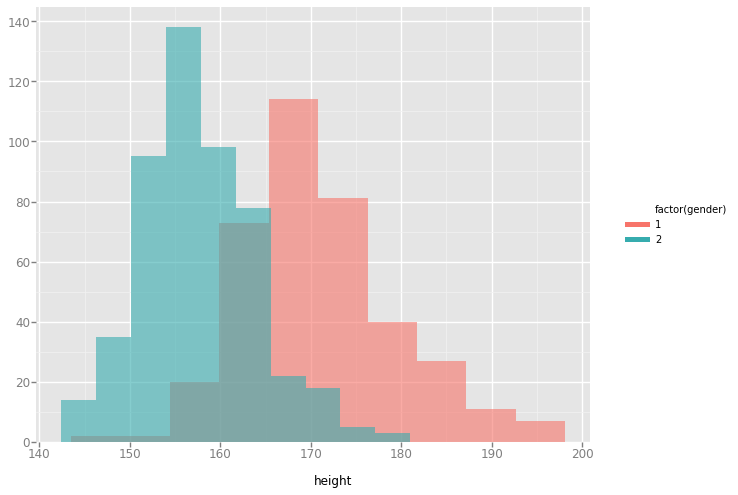

<ggplot: (-9223363300284316977)>

In [272]:
samp_size=len(all_meta)
train_ratio = 0.75
#train_ratio = 0.9
train_size = int(samp_size * train_ratio)

import random
val_idx = random.sample(range(samp_size), samp_size-train_size)
print(samp_size,train_size)
ggplot( aes(x='height',fill='factor(gender)'),data=all_meta.loc[val_idx]) +\
    geom_histogram(alpha=0.6)

## Random Forest

In [282]:
y = np.array(y)

In [283]:
from sklearn.ensemble import RandomForestRegressor
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, X.values, y)

m = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
m.fit(trn, y_trn)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.99, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [3]:
preds = m.predict(val)

NameError: name 'm' is not defined

In [285]:
m.score(trn, y_trn), m.score(val, y_val), m.oob_score_

(0.8439407662079724, 0.11804699118137751, 0.0804589756030738)

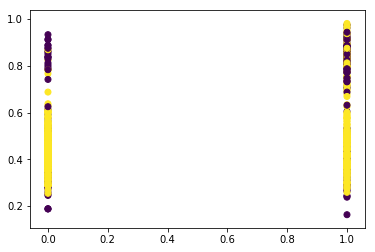

In [286]:
plt.scatter(y_val,preds,c=list(val[:,7726]), marker='o')

In [2]:
heights = m.predict(df_test).tolist()
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
challenge.submit(heights)
challenge.disconnect()

NameError: name 'm' is not defined

## NN1

In [1]:
cat_vars = ['gender','nationality']
contin_vars = X.columns[:-2]

NameError: name 'X' is not defined

In [194]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, X, y.astype(np.float32), cat_flds=cat_vars, bs=128,
                                       test_df=df_test,is_reg=False)

In [195]:
cat_sz = [(c, 3) for c in cat_vars]
cat_sz

[('gender', 3), ('nationality', 3)]

In [196]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
emb_szs

[(3, 2), (3, 2)]

In [197]:
y_range = (130,210)

In [198]:
#m = md.get_learner(emb_szs, len(X.columns)-len(cat_vars),
#                   0, 1, [256,128,64], [0.3,0.5,0.3], y_range=y_range)

In [213]:
m = md.get_learner(emb_szs, len(X.columns)-len(cat_vars),
                   0, 1, [128,64,16], [0,0.1,0.1])

In [214]:
lr = 1e-3

In [227]:
m.lr_find()

 43%|████▎     | 9/21 [00:00<00:00, 87.59it/s, loss=46.3]


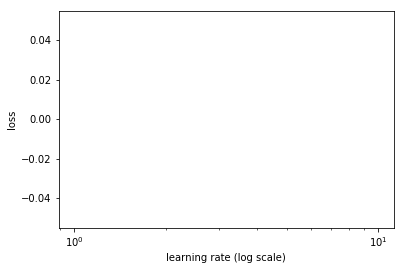

In [228]:
m.sched.plot()

In [229]:
m.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss                            
    0      55.250753  62.687112 
    1      58.415913  64.20576                             
    2      56.39197   62.964787                          



[array([62.96479])]

In [230]:
m.fit(lr, 10, cycle_len=1)

epoch      trn_loss   val_loss                            
    0      56.733091  62.744966 
    1      49.164127  62.002885                            
    2      44.179577  61.256397                          
    3      42.012801  60.872404                            
    4      39.967664  60.322566                          
    5      43.533669  60.629964                            
    6      42.154946  58.021469                          
    7      41.29138   57.008608                          
    8      40.034128  56.676835                          
    9      40.916238  60.169139                            



[array([60.16914])]

In [983]:
m.save('nn_model1') #R2=0.355

 24%|██▍       | 12/50 [00:00<00:00, 119.82it/s, loss=43.2]

epoch      trn_loss   val_loss                             
    0      80.888028  151.194055



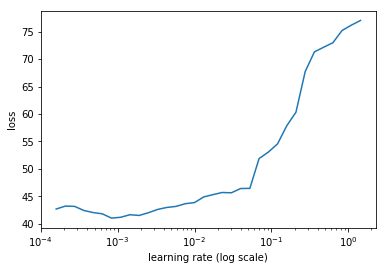

In [984]:
m.lr_find()
m.sched.plot()

In [985]:
m.fit(0.01, 3, cycle_len=1)

epoch      trn_loss   val_loss                             
    0      50.995664  42.544632 
    1      43.480691  41.338056                            
    2      42.126355  41.464497                            



[array([41.4645])]

In [1026]:
m.fit(lr, 10, cycle_len=1)

epoch      trn_loss   val_loss                            
    0      57.78584   49.578513 
    1      53.775634  46.085355                            
    2      51.614049  43.825487                            
    3      50.302809  40.732563                            
    4      49.565065  43.737697                           
    5      47.954103  40.983987                            
    6      47.264173  38.763312                          
    7      46.305101  38.572067                            
    8      45.49319   38.968085                            
    9      46.022123  39.092998                            



[array([39.093])]

In [987]:
m.save('nn_model2') #R2=0.436

In [9]:
m.load('nn_model2')

NameError: name 'm' is not defined

In [231]:
# Predict the heights for the test set
heights = m.predict(True)
heights=heights.reshape(137)
heights = heights.tolist()
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
challenge.submit(heights)
challenge.disconnect()

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : adf40834-afd7-4b4d-bb1d-a0116c14b777


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : adf40834-afd7-4b4d-bb1d-a0116c14b777


100% |██████████|[00:00<00:00]  109.49% /s] 


CrowdAI.Event.Job.INFO : (adf40834-afd7-4b4d-bb1d-a0116c14b777) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.073840333075 ; MSE : 94.1487447856
CrowdAI.Event.Job.COMPLETE : adf40834-afd7-4b4d-bb1d-a0116c14b777	   🍺 


## NN2

In [972]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(y)
y_range = (140,200)

In [317]:
maf=pd.read_csv('../predict_height/lib/maf.csv',index_col=0)

In [321]:
sum([x in maf.index for x in all_bim.snp])

628

In [792]:
# Instantiate a linear model
x_train=X
y_train=y
x_test=df_test
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)

# Predict the heights for the test set
heights = regr.predict(x_test)

In [793]:
#Convert heights from np.array to a list (to ensure it is JSON serializable)
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")

heights = heights.tolist()
challenge.submit(heights)
challenge.disconnect()

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[16:49<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : bc1ef311-9598-4a6c-a9a2-cce75662d779



          
  0% |          |[16:49<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : bc1ef311-9598-4a6c-a9a2-cce75662d779



          
  0% |          |[16:49<?]  ?% /s] 
100% |██████████|[00:00<00:00]  102.69% /s] 
          
  0% |          |[16:49<?]  ?% /s] .69% /s] 


CrowdAI.Event.Job.INFO : (bc1ef311-9598-4a6c-a9a2-cce75662d779) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.0365818509984 ; MSE : 105.373709981
CrowdAI.Event.Job.COMPLETE : bc1ef311-9598-4a6c-a9a2-cce75662d779	   🍺 


In [ ]:
import preprocess
import argparse
import models


def init_args():
    parser = argparse.ArgumentParser(description='Train and save models')
    parser.add_argument('train_datesets', help='Input csv file for training output from parse_inputs.py')
    parser.add_argument('-m', '--model', help='Train model, comma to separate', default='gbr')
    parser.add_argument('-d', '--model-dir', help='Model directory', default='models')
    parser.add_argument('-l', '--list-models', help='List available models', action='store_true')
    args = parser.parse_args()
    return args


def main():
    args = init_args()
    if args.list_models:
        print('\n'.join(models.get_model_names()))
        exit()
    m = args.model.split(',')
    dict_m = models.get_models(m)
    x, y = preprocess.load_data(args.train_datesets)
    for model_name in dict_m:
        model = dict_m[model_name]
        print('Training model %s' % model_name)
        model.fit(x, y)
        models.save_model(model, model_name, args.model_dir)
        print('Train finished, save to %s' % args.model_dir)

